<a href="https://colab.research.google.com/github/ariahosseini/TradML/blob/main/ML_CatBoost_ProjTwe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import math
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from sklearn import metrics
from sklearn.model_selection import train_test_split
from catboost import *
from catboost.eval.catboost_evaluation import *
from catboost.eval.evaluation_result import *
from catboost import datasets
from catboost.utils import create_cd, get_roc_curve, get_fpr_curve, get_fnr_curve, select_threshold

In [ ]:
np.set_printoptions(precision=4)

In [ ]:
(train_df, test_df) = datasets.amazon()
train_df.head()

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


In [ ]:
y = train_df.ACTION
X = train_df.drop('ACTION', axis=1)

In [ ]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)
print('Labels: {}'.format(set(y)))
print('Zero count = {}, One count = {}'.format(len(y) - sum(y), sum(y)))

[0, 1, 2, 3, 4, 5, 6, 7, 8]
Labels: {0, 1}
Zero count = 1897, One count = 30872


In [ ]:
dataset_dir = './amazon'
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.tsv'),
    index=False, sep='\t', header=False
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.tsv'),
    index=False, sep='\t', header=False
)

train_df.to_csv(
    os.path.join(dataset_dir, 'train.csv'),
    index=False, sep=',', header=True
)
test_df.to_csv(
    os.path.join(dataset_dir, 'test.csv'),
    index=False, sep=',', header=True
)

In [ ]:
!head amazon/train.csv

ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,17183,1540,117961,118343,123125,118536,118536,308574,118539
1,36724,14457,118219,118220,117884,117879,267952,19721,117880
1,36135,5396,117961,118343,119993,118321,240983,290919,118322
1,42680,5905,117929,117930,119569,119323,123932,19793,119325
0,45333,14561,117951,117952,118008,118568,118568,19721,118570
1,25993,17227,117961,118343,123476,118980,301534,118295,118982
1,19666,4209,117961,117969,118910,126820,269034,118638,126822
1,31246,783,117961,118413,120584,128230,302830,4673,128231


In [ ]:
feature_names = dict()
for column, name in enumerate(train_df):
    if column == 0:
        continue
    feature_names[column] = name

create_cd(
    label=0,
    cat_features=list(range(1, train_df.columns.shape[0])),
    feature_names=feature_names,
    output_path=os.path.join(dataset_dir, 'train.cd')
)

In [ ]:
!cat amazon/train.cd

0	Label	
1	Categ	RESOURCE
2	Categ	MGR_ID
3	Categ	ROLE_ROLLUP_1
4	Categ	ROLE_ROLLUP_2
5	Categ	ROLE_DEPTNAME
6	Categ	ROLE_TITLE
7	Categ	ROLE_FAMILY_DESC
8	Categ	ROLE_FAMILY
9	Categ	ROLE_CODE


In [ ]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)
pool2 = Pool(
    data=os.path.join(dataset_dir, 'train.csv'),
    delimiter=',',
    column_description=os.path.join(dataset_dir, 'train.cd'),
    has_header=True
)
pool3 = Pool(data=X, cat_features=cat_features)

X_prepared = X.values.astype(str).astype(object)

pool4 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

print('Dataset shape')
print('dataset 1:' + str(pool1.shape) +
      '\ndataset 2:' + str(pool2.shape) +
      '\ndataset 3:' + str(pool3.shape) +
      '\ndataset 4: ' + str(pool4.shape))

print('\n')
print('Column names')
print('dataset 1:')
print(pool1.get_feature_names())
print('\ndataset 2:')
print(pool2.get_feature_names())
print('\ndataset 3:')
print(pool3.get_feature_names())
print('\ndataset 4:')
print(pool4.get_feature_names())

Dataset shape
dataset 1:(32769, 9)
dataset 2:(32769, 9)
dataset 3:(32769, 9)
dataset 4: (32769, 9)


Column names
dataset 1:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 2:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 3:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']

dataset 4:
['RESOURCE', 'MGR_ID', 'ROLE_ROLLUP_1', 'ROLE_ROLLUP_2', 'ROLE_DEPTNAME', 'ROLE_TITLE', 'ROLE_FAMILY_DESC', 'ROLE_FAMILY', 'ROLE_CODE']


In [ ]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=1234)

In [ ]:
model = CatBoostClassifier(
    iterations=5,
    learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{'iterations': 5, 'learning_rate': 0.1}


In [ ]:
model = CatBoostClassifier(
    iterations=15,
#     verbose=5,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
)

Learning rate set to 0.441257
0:	learn: 0.4220777	test: 0.4223741	best: 0.4223741 (0)	total: 9.54ms	remaining: 134ms
1:	learn: 0.3149660	test: 0.3151186	best: 0.3151186 (1)	total: 19.9ms	remaining: 129ms
2:	learn: 0.2621494	test: 0.2629766	best: 0.2629766 (2)	total: 28.3ms	remaining: 113ms
3:	learn: 0.2302316	test: 0.2302315	best: 0.2302315 (3)	total: 38.2ms	remaining: 105ms
4:	learn: 0.2060274	test: 0.2019603	best: 0.2019603 (4)	total: 46.8ms	remaining: 93.6ms
5:	learn: 0.1956107	test: 0.1894627	best: 0.1894627 (5)	total: 54.9ms	remaining: 82.3ms
6:	learn: 0.1870345	test: 0.1790904	best: 0.1790904 (6)	total: 63.3ms	remaining: 72.3ms
7:	learn: 0.1836943	test: 0.1748030	best: 0.1748030 (7)	total: 70.9ms	remaining: 62.1ms
8:	learn: 0.1807119	test: 0.1707896	best: 0.1707896 (8)	total: 79ms	remaining: 52.7ms
9:	learn: 0.1775777	test: 0.1662489	best: 0.1662489 (9)	total: 89ms	remaining: 44.5ms
10:	learn: 0.1762130	test: 0.1654446	best: 0.1654446 (10)	total: 97.9ms	remaining: 35.6ms
11:	lear

In [ ]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=63,
    learning_rate=0.5,
    custom_loss=['AUC', 'Accuracy']
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
model1 = CatBoostClassifier(
    learning_rate=0.7,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.7'
)

model2 = CatBoostClassifier(
    learning_rate=0.01,
    iterations=100,
    random_seed=0,
    train_dir='learing_rate_0.01'
)
model1.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
model2.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [ ]:
MetricVisualizer(['learing_rate_0.01', 'learing_rate_0.7']).start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
model = CatBoostClassifier(
    iterations=100,
    random_seed=63,
    learning_rate=0.5,
#     use_best_model=False
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print('Tree count: ' + str(model.tree_count_))

Tree count: 82


In [ ]:
params = {}
params['loss_function'] = 'Logloss'
params['iterations'] = 80
params['custom_loss'] = 'AUC'
params['random_seed'] = 63
params['learning_rate'] = 0.5

cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=False,
    verbose=False
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1695893693
bestIteration = 38

Training on fold [1/5]

bestTest = 0.1646328641
bestIteration = 48

Training on fold [2/5]

bestTest = 0.1515742763
bestIteration = 60

Training on fold [3/5]

bestTest = 0.1426916182
bestIteration = 78

Training on fold [4/5]

bestTest = 0.1563234371
bestIteration = 37



In [ ]:
cv_data.head()

,iterations,test-Logloss-mean,test-Logloss-std,train-Logloss-mean,train-Logloss-std,test-AUC-mean,test-AUC-std
0,0,0.302367,0.004317,0.302196,0.004517,0.513577,0.030360
1,1,0.227370,0.007679,0.228497,0.005126,0.642263,0.048004
2,2,0.190856,0.006917,0.196796,0.003999,0.791709,0.011361
3,3,0.178884,0.007455,0.186682,0.003242,0.813889,0.009362
4,4,0.172286,0.007957,0.181380,0.002135,0.826529,0.005319


In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, not stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

Best validation Logloss score, not stratified: 0.1581±0.0104 on step 52


In [ ]:
cv_data = cv(
    params = params,
    pool = Pool(X, label=y, cat_features=cat_features),
    fold_count=5,
    type = 'Classical',
    shuffle=True,
    partition_random_seed=0,
    plot=True,
    stratified=True,
    verbose=False
)

best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])

print('Best validation Logloss score, stratified: {:.4f}±{:.4f} on step {}'.format(
    best_value,
    cv_data['test-Logloss-std'][best_iter],
    best_iter)
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Training on fold [0/5]

bestTest = 0.1614486451
bestIteration = 31

Training on fold [1/5]

bestTest = 0.1551886688
bestIteration = 56

Training on fold [2/5]

bestTest = 0.156915781
bestIteration = 57

Training on fold [3/5]

bestTest = 0.1521221373
bestIteration = 59

Training on fold [4/5]

bestTest = 0.1576264978
bestIteration = 29

Best validation Logloss score, stratified: 0.1574±0.0036 on step 57


In [ ]:
model_with_early_stop = CatBoostClassifier(
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print(model_with_early_stop.tree_count_)

30


In [ ]:
model_with_early_stop = CatBoostClassifier(
    eval_metric='AUC',
    iterations=200,
    random_seed=63,
    learning_rate=0.5,
    early_stopping_rounds=20
)
model_with_early_stop.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
print(model_with_early_stop.tree_count_)

30


In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)
eval_pool = Pool(X_validation, y_validation, cat_features=cat_features)
curve = get_roc_curve(model, eval_pool)
(fpr, tpr, thresholds) = curve
roc_auc = metrics.auc(fpr, tpr)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

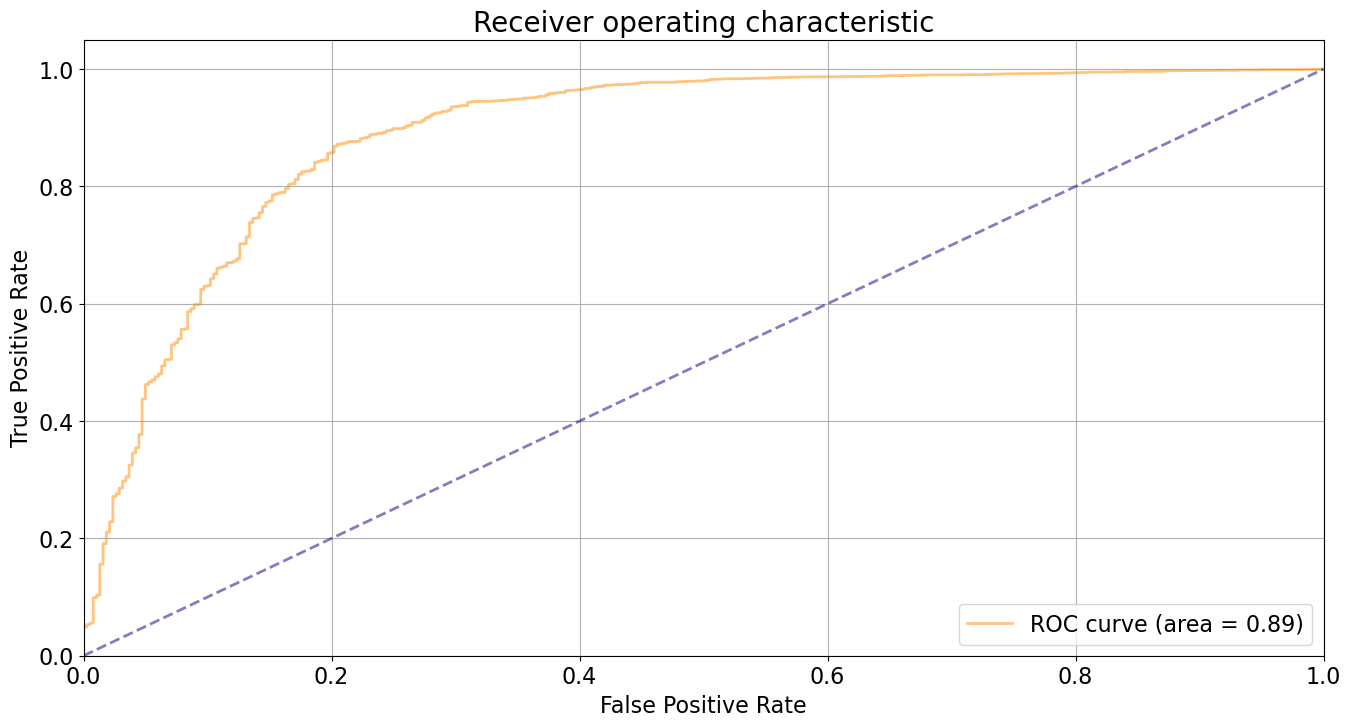

In [ ]:
plt.figure(figsize=(16, 8))
lw = 2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
(thresholds, fpr) = get_fpr_curve(curve=curve)
(thresholds, fnr) = get_fnr_curve(curve=curve)

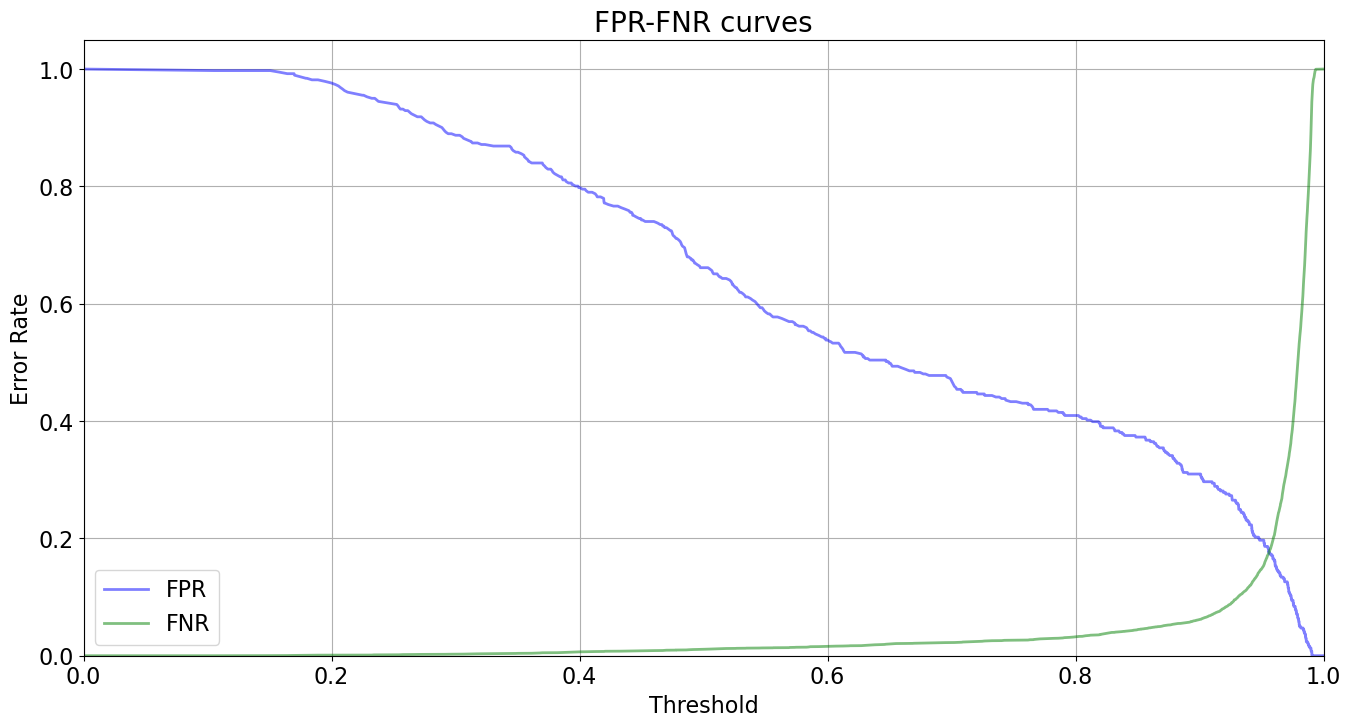

In [ ]:
lw = 2
plt.figure(figsize=(16, 8))
plt.plot(thresholds, fpr, color='blue', lw=lw, label='FPR', alpha=0.5)
plt.plot(thresholds, fnr, color='green', lw=lw, label='FNR', alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('Threshold', fontsize=16)
plt.ylabel('Error Rate', fontsize=16)
plt.title('FPR-FNR curves', fontsize=20)
plt.legend(loc="lower left", fontsize=16)
plt.show()

In [ ]:
print(select_threshold(model=model, data=eval_pool, FNR=0.01))
print(select_threshold(model=model, data=eval_pool, FPR=0.01))

0.48689529945049076
0.9899713850692811


In [ ]:
# !rm 'catboost_info/snapshot.bkp'
from catboost import CatBoostClassifier
model = CatBoostClassifier(
    iterations=100,
    save_snapshot=True,
    snapshot_file='snapshot.bkp',
    snapshot_interval=1,
    random_seed=43
)
model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)

In [ ]:
print(model.predict_proba(X=X_validation))
print(model.predict(data=X_validation))

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]
[1 1 1 ... 1 1 1]


In [ ]:
raw_pred = model.predict(
    data=X_validation,
    prediction_type='RawFormulaVal'
)
print(raw_pred)

sigmoid = lambda x: 1 / (1 + np.exp(-x))
probabilities = sigmoid(raw_pred)
print(probabilities)

[2.9282 3.9947 4.0077 ... 4.1115 4.06   3.7207]
[0.9492 0.9819 0.9821 ... 0.9839 0.983  0.9764]


In [ ]:
X_prepared = X_validation.values.astype(str).astype(object)
# For FeaturesData class categorial features must have type str
fast_predictions = model.predict_proba(
    X=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X_validation)
    )
)
print(fast_predictions)

[[0.0508 0.9492]
 [0.0181 0.9819]
 [0.0179 0.9821]
 ...
 [0.0161 0.9839]
 [0.017  0.983 ]
 [0.0236 0.9764]]


In [ ]:
predictions_gen = model.staged_predict_proba(
    data=X_validation,
    ntree_start=0,
    ntree_end=5,
    eval_period=1
)
try:
    for iteration, predictions in enumerate(predictions_gen):
        print('Iteration ' + str(iteration) + ', predictions:')
        print(predictions)
except Exception:
    pass

Iteration 0, predictions:
[[0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]
 ...
 [0.4154 0.5846]
 [0.4154 0.5846]
 [0.4154 0.5846]]
Iteration 1, predictions:
[[0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]
 ...
 [0.3476 0.6524]
 [0.3476 0.6524]
 [0.3476 0.6524]]
Iteration 2, predictions:
[[0.292  0.708 ]
 [0.292  0.708 ]
 [0.2978 0.7022]
 ...
 [0.2978 0.7022]
 [0.292  0.708 ]
 [0.2978 0.7022]]
Iteration 3, predictions:
[[0.2485 0.7515]
 [0.2485 0.7515]
 [0.2538 0.7462]
 ...
 [0.2538 0.7462]
 [0.2485 0.7515]
 [0.2538 0.7462]]
Iteration 4, predictions:
[[0.2126 0.7874]
 [0.2126 0.7874]
 [0.2173 0.7827]
 ...
 [0.2173 0.7827]
 [0.2126 0.7874]
 [0.2173 0.7827]]


In [ ]:
model = CatBoostClassifier(
    iterations=50,
    random_seed=43,
    loss_function='MultiClass'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
def build_multiclass_ranking_dataset(X, y, cat_features, label_values=[0,1], start_group_id=0):
    ranking_matrix = []
    ranking_labels = []
    group_ids = []

    X_train_matrix = X.values
    y_train_vector = y.values

    for obj_idx in range(X.shape[0]):
        obj = list(X_train_matrix[obj_idx])

        for label in label_values:
            obj_of_given_class = deepcopy(obj)
            obj_of_given_class.append(label)
            ranking_matrix.append(obj_of_given_class)
            ranking_labels.append(float(y_train_vector[obj_idx] == label))
            group_ids.append(start_group_id + obj_idx)

    final_cat_features = deepcopy(cat_features)
    final_cat_features.append(X.shape[1]) # new feature that we are adding should be categorical.
    return Pool(ranking_matrix, ranking_labels, cat_features=final_cat_features, group_id = group_ids)

In [ ]:
params = {'iterations':150, 'learning_rate':0.01, 'l2_leaf_reg':30,
          'random_seed':0, 'loss_function':'QuerySoftMax'}

groupwise_train_pool = build_multiclass_ranking_dataset(X_train, y_train, cat_features, [0,1])
groupwise_eval_pool = build_multiclass_ranking_dataset(X_validation, y_validation, cat_features,
                                                       [0,1], X_train.shape[0])

model = CatBoost(params)
model.fit(
    X=groupwise_train_pool,
    verbose=False,
    eval_set=groupwise_eval_pool,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
obj = list(X_validation.values[0])
ratings = []
for label in [0,1]:
    obj_with_label = deepcopy(obj)
    obj_with_label.append(label)
    rating = model.predict([obj_with_label])[0]
    ratings.append(rating)
print('Raw values:', np.array(ratings))

def soft_max(values):
    return [math.exp(val) / sum([math.exp(val) for val in values]) for val in values]

print('Probabilities', np.array(soft_max(ratings)))

Raw values: [-0.471   0.4713]
Probabilities [0.2804 0.7196]


In [ ]:
model = CatBoostClassifier(
    random_seed=63,
    iterations=200,
    learning_rate=0.03,
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=50
)
metrics = model.eval_metrics(
    data=pool1,
    metrics=['Logloss','AUC'],
    ntree_start=0,
    ntree_end=0,
    eval_period=1,
    plot=True
)

print('AUC values:')
print(np.array(metrics['AUC']))

model.get_feature_importance(prettified=True)
shap_values = model.get_feature_importance(pool1, type='ShapValues')
expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]
print(shap_values.shape)

0:	learn: 0.6569860	total: 18ms	remaining: 3.58s
50:	learn: 0.1923495	total: 1.09s	remaining: 3.19s
100:	learn: 0.1655631	total: 2.31s	remaining: 2.26s
150:	learn: 0.1570882	total: 3.72s	remaining: 1.21s
199:	learn: 0.1538475	total: 5.18s	remaining: 0us


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

AUC values:
[0.4998 0.538  0.5504 0.5888 0.6536 0.6515 0.6476 0.648  0.7117 0.731
 0.7277 0.7278 0.7299 0.7298 0.7275 0.7273 0.7336 0.735  0.7445 0.7606
 0.7627 0.7627 0.7731 0.7769 0.7866 0.7985 0.7986 0.8008 0.8004 0.8004
 0.8191 0.8357 0.8518 0.8666 0.8851 0.8855 0.8886 0.8931 0.8936 0.8991
 0.9033 0.9115 0.9126 0.9136 0.9148 0.9163 0.9177 0.9184 0.9206 0.9211
 0.9259 0.9289 0.9291 0.9324 0.9329 0.9334 0.9338 0.9351 0.9361 0.937
 0.9378 0.938  0.9383 0.9393 0.9405 0.9416 0.943  0.9441 0.945  0.9448
 0.9457 0.9458 0.9463 0.9464 0.9467 0.9469 0.9484 0.9494 0.9503 0.9515
 0.9523 0.9528 0.9539 0.9546 0.955  0.9556 0.9559 0.9563 0.9565 0.9567
 0.9572 0.9576 0.9583 0.9591 0.9602 0.9608 0.9613 0.9619 0.9622 0.9625
 0.9629 0.9633 0.9637 0.9639 0.9647 0.9655 0.9661 0.9667 0.9673 0.9675
 0.9682 0.9687 0.9691 0.9694 0.9699 0.9703 0.9706 0.9707 0.9711 0.9715
 0.9716 0.972  0.9723 0.9726 0.9728 0.973  0.9731 0.9731 0.9733 0.9734
 0.9738 0.9738 0.9739 0.974  0.9741 0.9742 0.9744 0.9744 0.9745 0.9

In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[3,:], X.iloc[3,:])

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [ ]:
shap.initjs()
shap.force_plot(expected_value, shap_values[91,:], X.iloc[91,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


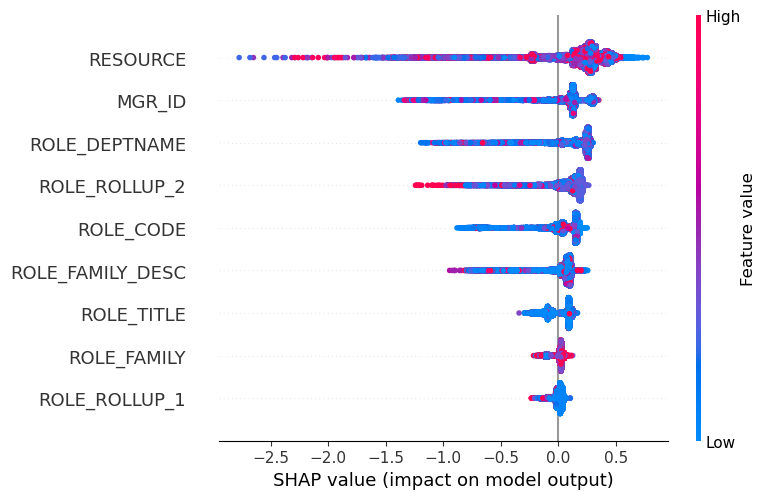

In [ ]:
shap.summary_plot(shap_values, X)

In [ ]:
X_small = X.iloc[0:200]
shap_small = shap_values[:200]
shap.force_plot(expected_value, shap_small, X_small)

In [ ]:
learn_params = {'iterations': 20, # 2000
                'learning_rate': 0.5, # we set big learning_rate,
                                      # because we have small
                                      # #iterations
                'random_seed': 0,
                'verbose': False,
                'loss_function' : 'Logloss',
                'boosting_type': 'Plain'}
evaluator = CatboostEvaluation('amazon/train.tsv',
                               fold_size=10000, # <= 50% of dataset
                               fold_count=20,
                               column_description='amazon/train.cd',
                               partition_random_seed=0,
                               #working_dir=...
)
result = evaluator.eval_features(learn_config=learn_params,
                                 eval_metrics=['Logloss', 'Accuracy'],
                                 features_to_eval=[6, 7, 8])
logloss_result = result.get_metric_results('Logloss')
logloss_result.get_baseline_comparison(
    ScoreConfig(ScoreType.Rel, overfit_iterations_info=False)
)

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to 

,PValue,Score,Quantile 0.005,Quantile 0.995,Decision
Features: 6,0.000189,1.010962,0.563095,1.467095,GOOD
Features: 7,0.681322,-0.033237,-0.307707,0.262332,UNKNOWN
Features: 8,0.005111,-0.439271,-0.796507,-0.134751,BAD


In [ ]:
my_best_model = CatBoostClassifier(iterations=10)
my_best_model.fit(
    X_train, y_train,
    eval_set=(X_validation, y_validation),
    cat_features=cat_features,
    verbose=False
)
my_best_model.save_model('catboost_model.bin')
my_best_model.save_model('catboost_model.json', format='json')

my_best_model.load_model('catboost_model.bin')
print(my_best_model.get_params())
print(my_best_model.random_seed_)

In [ ]:
fast_model = CatBoostClassifier(
    random_seed=63,
    iterations=150,
    learning_rate=0.01,
    boosting_type='Plain',
    bootstrap_type='Bernoulli',
    subsample=0.5,
    one_hot_max_size=20,
    rsm=0.5,
    leaf_estimation_iterations=5,
    max_ctr_complexity=1)

fast_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    plot=True
)

tunned_model = CatBoostClassifier(
    random_seed=63,
    iterations=1000,
    learning_rate=0.03,
    l2_leaf_reg=3,
    bagging_temperature=1,
    random_strength=1,
    one_hot_max_size=2,
    leaf_estimation_method='Newton'
)
tunned_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    verbose=False,
    eval_set=(X_validation, y_validation),
    plot=True
)

best_model = CatBoostClassifier(
    random_seed=63,
    iterations=int(tunned_model.tree_count_ * 1.2),
)
best_model.fit(
    X, y,
    cat_features=cat_features,
    verbose=100
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.042562
0:	learn: 0.6431230	total: 15ms	remaining: 16.2s
100:	learn: 0.1543277	total: 2.94s	remaining: 28.5s
200:	learn: 0.1468157	total: 6.43s	remaining: 28.2s
300:	learn: 0.1432971	total: 9.99s	remaining: 25.9s
400:	learn: 0.1394889	total: 13.4s	remaining: 22.6s
500:	learn: 0.1366166	total: 16.9s	remaining: 19.5s
600:	learn: 0.1336685	total: 20.7s	remaining: 16.6s
700:	learn: 0.1305189	total: 24.6s	remaining: 13.3s
800:	learn: 0.1278539	total: 28.4s	remaining: 9.94s
900:	learn: 0.1250599	total: 32.1s	remaining: 6.42s
1000:	learn: 0.1223452	total: 35.7s	remaining: 2.85s
1080:	learn: 0.1201653	total: 38.7s	remaining: 0us


In [ ]:
X_test = test_df.drop('id', axis=1)
test_pool = Pool(data=X_test, cat_features=cat_features)
contest_predictions = best_model.predict_proba(test_pool)
print('Predictoins:')
print(contest_predictions)

Predictoins:
[[0.2987 0.7013]
 [0.018  0.982 ]
 [0.0137 0.9863]
 ...
 [0.0049 0.9951]
 [0.0384 0.9616]
 [0.013  0.987 ]]


In [ ]:
f = open('submit.csv', 'w')
f.write('Id,Action\n')
for idx in range(len(contest_predictions)):
    line = str(test_df['id'][idx]) + ',' + str(contest_predictions[idx][1]) + '\n'
    f.write(line)
f.close()